In [1]:
import torch
import numpy as np
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'VGGish'#'PANNs'#'YAMNet' #'VGGish'#'AI'
mod_encoder = 'GCN'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA01_vggish.pickle'
n_feat=128
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 128])
1
RZUA02
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA02_vggish.pickle'
n_feat=128
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 128])
2
RZUA04
file_path='/home/labmirp/Documentos/AECO//AECO/DeepFeatures_data/ReyZamuro/RZUA04_vggish.pickle'
n_feat=128
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 128])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True


128

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del graphs, x, unpacked_data, train_dataset

## Cargar modelo

In [12]:
from models import MatrixGCNVAE_MT, MatrixGATVAE_MT

In [13]:
if mod_encoder == "GCN":
    model = MatrixGCNVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
elif mod_encoder == "GAT":
    model = MatrixGATVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
else:
    print("Error")

In [14]:
#load model
model.load_state_dict(torch.load(f'modelsGVAE_semi/{features}_{mod_encoder}_model_weights.pth'))

<All keys matched successfully>

In [15]:
from torchsummary import summary
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            1,600
├─GCNConv: 1-2                           --
|    └─SumAggregation: 2-1               --
|    └─Linear: 2-2                       4,194,304
├─BatchNorm1d: 1-3                       1,024
├─GCNConv: 1-4                           --
|    └─SumAggregation: 2-3               --
|    └─Linear: 2-4                       8,192
├─GCNConv: 1-5                           --
|    └─SumAggregation: 2-5               --
|    └─Linear: 2-6                       8,192
├─Linear: 1-6                            8,704
├─Linear: 1-7                            1,575,936
├─Sequential: 1-8                        --
|    └─Linear: 2-7                       8,704
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       47,196
├─Sequential: 1-9                        --
|    └─Linear: 2-10                      136
|    └─ReLU: 2-11                        --
|    └─Dropout: 2-12              

## Eval


In [16]:
# Generate embeddings
model.eval()
model.double()
embeddings = torch.empty(92,0)
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar,_ = model(graph.x.double(), graph.edge_index)
        embs = model.reparameterize(mu, logvar)
        embeddings = torch.cat((embeddings,mu), dim = 1)

In [17]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 48])


In [18]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [19]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)/int(num_feat/8)
sim_mat

array([[0.7960803 , 0.78740876, 0.71625989, ..., 0.60395395, 0.58541505,
        0.71909942],
       [0.78740876, 0.77938362, 0.71074133, ..., 0.59617971, 0.57834088,
        0.71337862],
       [0.71625989, 0.71074133, 0.83543889, ..., 0.61590013, 0.63471996,
        0.78471185],
       ...,
       [0.60395395, 0.59617971, 0.61590013, ..., 0.93399038, 0.60836428,
        0.78616417],
       [0.58541505, 0.57834088, 0.63471996, ..., 0.60836428, 0.73112181,
        0.64675179],
       [0.71909942, 0.71337862, 0.78471185, ..., 0.78616417, 0.64675179,
        0.90503574]])

In [20]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [22]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

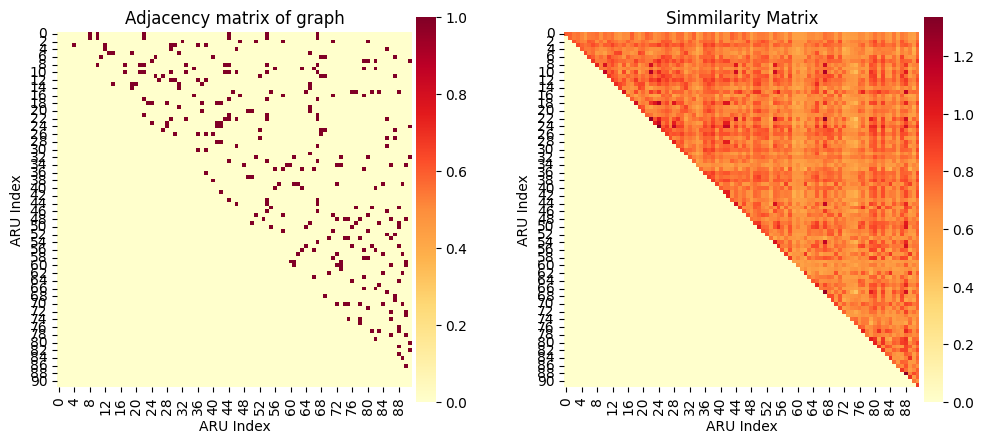

In [23]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

## Post-process graph

In [24]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=8)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 48], edge_index=[2, 926]) connected? True
Is the graph undirected True


In [25]:
adj_init = edge_index_to_adjacency(graph.edge_index)
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

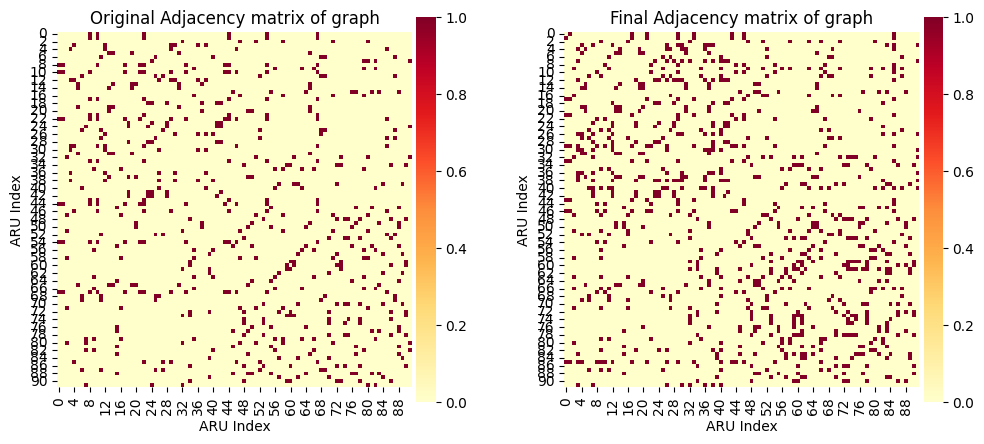

In [26]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(adj_init, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Original Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
# sns.heatmap(adj_final*sim_mat, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
sns.heatmap(adj_final, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Final Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

In [27]:
import networkx as nx

def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [28]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [29]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [30]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape

(926,)

In [31]:
graphs_[0].edge_weight = edge_weight

In [32]:
G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [33]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.7874087614934568}), (0, 17, {'weight': 0.79505474783366}), (0, 21, {'weight': 0.790763493048997}), (0, 29, {'weight': 0.749131308569532}), (0, 33, {'weight': 0.7873498136146759}), (0, 43, {'weight': 0.792706525168563}), (0, 46, {'weight': 0.7720521205625623}), (0, 85, {'weight': 0.7249504542458399}), (1, 17, {'weight': 0.7867141850732261}), (1, 21, {'weight': 0.782547645761695}), (1, 29, {'weight': 0.7434124655687058}), (1, 33, {'weight': 0.7791758084243134}), (1, 43, {'weight': 0.7843012608168212}), (1, 46, {'weight': 0.7656322022433025}), (1, 85, {'weight': 0.7203438912247732}), (2, 9, {'weight': 0.7372989675931133}), (2, 16, {'weight': 0.784977456558281}), (2, 32, {'weight': 0.7909593762652498}), (2, 47, {'weight': 0.8365984538768495}), (2, 51, {'weight': 0.8354388921307655}), (2, 58, {'weight': 0.828994554435297}), (2, 63, {'weight': 0.7492208138658899}), (2, 66, {'weight': 0.7372989675931134}), (2, 71, {'weight': 0.8365984538768495}), (2, 80, {'we

## Métricas

In [34]:
nx.density(G)


0.110606784519828

In [35]:
nx.diameter(G,weight="weight")

4.439528235702005

In [36]:
nx.average_shortest_path_length(G,weight="weight")

2.2753177559525817

In [37]:
# nx.betweenness_centrality(G, weight="weight")

/home/labmirp/miniconda3/envs/PyG/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


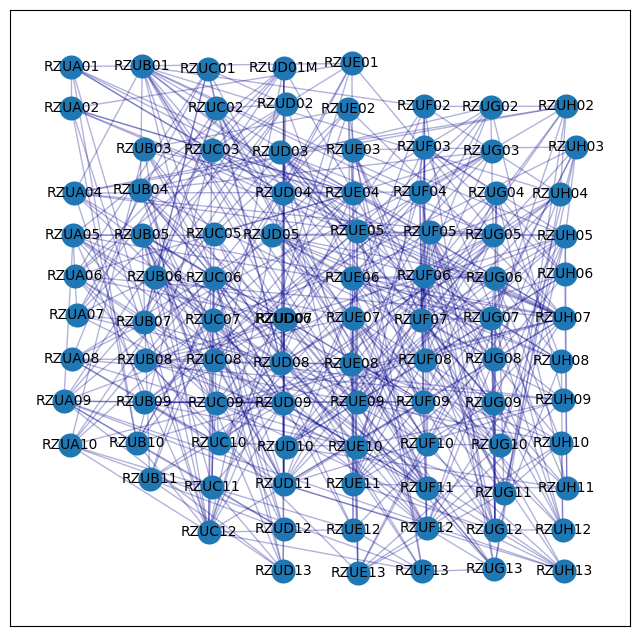

In [38]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [3*sim_mat[u,v]  for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

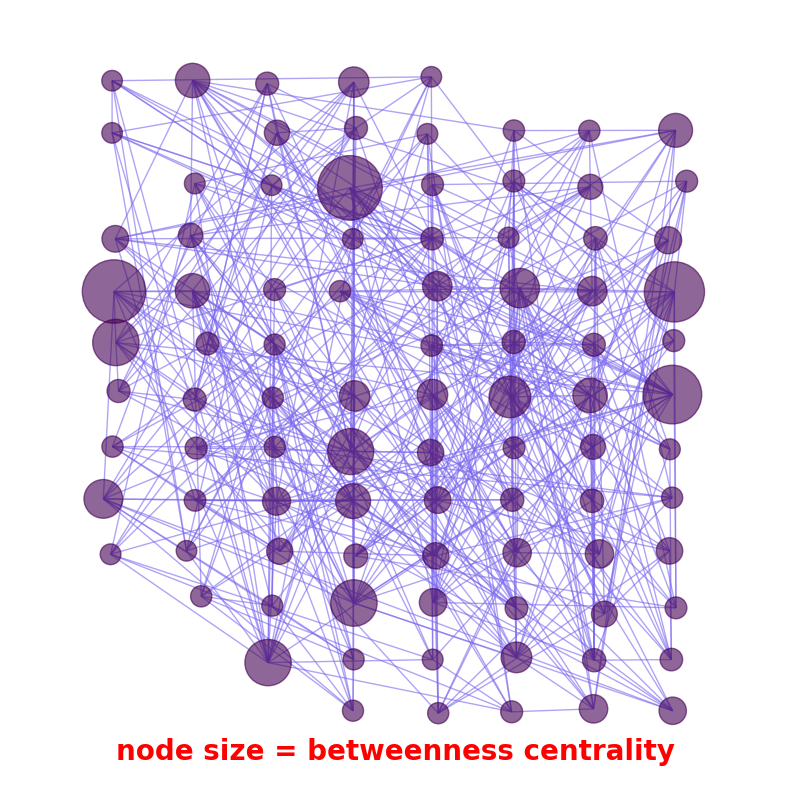

In [39]:
H = G.copy()
H.remove_node(35)
centrality = nx.betweenness_centrality(H, endpoints=True) #k=10

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)

# Title/legend
font = {"color": "r", "fontweight": "bold", "fontsize": 20}


ax.text(
    0.50,
    0.026,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

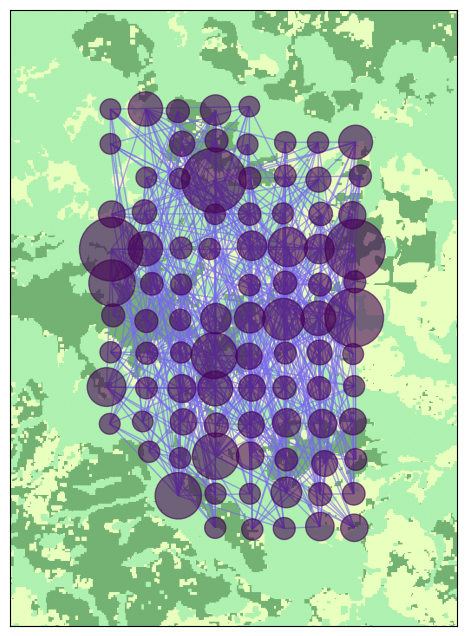

In [40]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

# plt.title("COB")
r = rasterio.plot.show(img, cmap=cmap, ax=ax)

# im = r.get_images()[0]
# fig.colorbar(im, ax=ax)

centrality = nx.betweenness_centrality(H, endpoints=True) #k = 10

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

fig.savefig(f'./results/graph_eb_geo_{features}_{mod_encoder}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()


## Fin